# ADK and PPT Theory of Atomic Ionization
[Fu Y-Z et.al.,  Chin. Phys. B 21 113101 (2012)]

In [2]:
import math as mt
import numpy as np

In [3]:
#function for temporal profile of laser
def temp_profile(t, fwhm, lam, phi = 0) :
    t = t*41 # in au
    fwhm = fwhm*41
    lam = lam*1e-9 #in nm
    w = 2*mt.pi*(3e8/lam)/4.13e16 #in au
    env = np.exp(-2*mt.log(2)*(t/fwhm)**2)
    return env*np.cos(w*t+phi), w, env

ADK Theory :

The static tunneling ionizaton rate is :

$W_{adk}(F) = |C_{n^*l^*}|^2 f(l,m) Eo \bigl(\dfrac{2F_o}{F}\bigr)^{2n^*-|m|-1}\times exp\bigl(-\dfrac{2F_o}{3F}\bigr)$

where

$F_o = (2E_o)^{3/2}$, $Eo$ is electron binding energy

$n^* = Z_c(2E_o)^{-1/2}$ is effecting principal quantum number and $Z_c$ is asymptotic charge

$l^* = n^*-1$ is effective orbital quantum number 

$F(t)$ is the electric field of pulse including the envelope and phase

$|C_{n^*l^*}|^2 = \dfrac{2^{2n^*}}{n^*\Gamma(n^*+l^*+1)\Gamma(n^*-l^*)}$

$f(l,m) = \dfrac{(2l+1)(l+|m|)!} {2^{|m|} |m|! (l-|m|)!}$

And the total ionization probability by a laser pulse is 

$P = 1 - exp\bigl(-\int_{-\infty}^{\infty} w_{ADK} |F(t)|dt\bigr)$

In [26]:
def P_ADK(Io, t, env, phase, w, Ip, Z, l, m):
    #assigning Io to numpy array
    if not isinstance(Io, np.ndarray):
        Io = np.asarray([Io])
    Fp = np.sqrt(2*Io*1e14*1e4/(3e8*8.854187817620e-12))*1e-2/5.14e9 #in au peak
    Ip = Ip/27.211396
    nstar = Z/mt.sqrt(2*Ip)
    lstar = nstar - 1
    C_nlstar_2 = 2**(2*nstar) \
                /nstar*mt.gamma(nstar+lstar+1) \
                /mt.gamma(nstar-lstar)
                
    f_lm = (2*l+1)*mt.factorial(l+mt.fabs(m)) \
            / 2**mt.fabs(m)*mt.factorial(mt.fabs(m)) \
            / mt.factorial(l-mt.fabs(m))

    Fo = np.sqrt(2*Ip)**3

    prob_ion = []
    dt = (t[1]-t[0])*41
    pulse = env*np.cos(w*t*41+phase)
    i_good = np.where(np.abs(pulse)>1e-50)
    pulse = pulse[i_good]
    for i in Fp:
        F = i*np.abs(pulse)
        #exponential term -> 0 faster than the power term so setting 0 is valid
        Wadk = C_nlstar_2*f_lm*Ip \
                * (2*Fo/F)**(2*nstar-mt.fabs(m)-1) \
                * np.exp(-2/3*Fo/F)                
        #total probability
        int_v = Wadk.sum()*dt 
        prob_adk = 1 - np.exp(-int_v)
        prob_ion.append(prob_adk)
    return np.asarray(prob_ion)

In [9]:
t = np.arange(-20,20,0.1)
pulse, w, env = temp_profile(t, 10, 800, 0)
dt = t[1]-t[0]

In [16]:
i, p = np.loadtxt('h.csv', delimiter=',', unpack=True)
Ip = 13.6 # ionization energy of Hydrogen atom in eV
I = np.arange(i.min(), i.max()+ 0.01, 0.05) # in 1e14 Watt/cm2

In [29]:
Padk = P_ADK(Io = I, t = t, env = env, phase= 0, w = w, Ip = Ip, Z = 1, l = 1, m = 0)

PPT Theory :

The cycle averaged ionization rate is 

$w_{PPT} = |C_{n^*l^*}|^2 f(l, m) Eo \bigl(\dfrac{2F_o}{F}\bigr)^{2n^*-|m|-1} \\
\times (1+\gamma^2)^{|m|/2+3/4} \\
\times A_m(\omega, \gamma) exp\bigl(-\dfrac{2F_o}{3F}g(\gamma)\bigr)\\
\times \sqrt{\dfrac{2F}{\pi F_o}}$

where

$g(\gamma) =  \dfrac{3}{2\gamma} (1+\dfrac{1}{2\gamma^2} sinh^{-1}\gamma - \dfrac{\sqrt{1+\gamma^2}}{2\gamma})$

$A_m(\omega, \gamma) = \dfrac{4}{\sqrt{3\pi}}\dfrac{1}{|m|!} \dfrac{\gamma^2}{1+\gamma^2} $

$\times\sum_{\kappa\geq\nu}^\infty e^{-\alpha(\gamma)(\kappa-\nu)}w_m(\sqrt{\beta(\gamma)(\kappa-\nu)})$

$w_m(x) = \dfrac{x^{2|m|+1}}{2}\int_0^1 \dfrac{e^{-x^2t}t^{|m|}} {\sqrt{1-t}} dt$

$\alpha(\gamma) = 2\bigl(sinh^{-1}\gamma - \dfrac{\gamma}{\sqrt{1+\gamma^2}}\bigr)$

$\beta(\gamma) = \dfrac{2\gamma}{\sqrt{1+\gamma^2}}$

$\nu = \dfrac{E_o}{\omega} \bigl(1+\dfrac{1}{2\gamma^2}\bigr)$

$\kappa = <\dfrac{E_o}{\omega}+1>+S $ and $S = 0, 1, ....$

In [19]:
import peakutils as pk #for counting peaks in pulse temporal profile
from scipy.special import dawsn

def wm(x,m):
    #from wolframalpha expressing the integral
    #exp(-x*x) int(exp(y*y)*(x**2-y**2)*dy, (0,x)) in Dawsn function
    if np.abs(m)==0:
        val = dawsn(x) 
    elif np.abs(m)==1:
        val = 1/2*(2*x**2*dawsn(x)+dawsn(x)-x)
    elif np.abs(m)==2:
        val = 1/4*((4*(x**4+x**2)+3)*dawsn(x)-x*(2*x**2+3))
    elif np.abs(m)==3:
        val = 1/8*((8*x**6+12*x**4+18*x**2+15)*dawsn(x)-x*(4*x**4+8*x**2+15))
    elif np.abs(m)==4:
        val = 1/16*((8*(2*x**6+4*x**4+9*x**2+15)*x**2+105)*dawsn(x)-x*(8*x**6+20*x**4+50*x**2+105))
    elif np.abs(m)==5:
        val = 1/32*((1050*x**2+8*(2*x**2+5)*(2*x**4+15)*x**4+945)*dawsn(x)-x*(16*x**8+48*x**6+152*x**4+420*x**2+945))
    return val


In [27]:
#cycle averaged ionization rate
def P_PPT(Io, t, env, phase, w, Ip, Z, l, m, N=50):
    if not isinstance(Io, np.ndarray):
        Io = np.asarray([Io])    
    Fp = np.sqrt(2*Io*1e14*1e4/(3e8*8.854187817620e-12))*1e-2/5.14e9 #in au peak
    Ip = Ip/27.211396
    nstar = Z/mt.sqrt(2*Ip)
    lstar = nstar - 1
    C_nlstar_2 = 2**(2*nstar) \
                 /nstar*mt.gamma(nstar+lstar+1) \
                 /mt.gamma(nstar-lstar)
                 
    f_lm = (2*l+1)*mt.factorial(l+mt.fabs(m)) \
            / 2**mt.fabs(m)*mt.factorial(mt.fabs(m)) \
            / mt.factorial(l-mt.fabs(m))

    Fo = np.sqrt(2*Ip)**3

    #find peaks so to sum for each cycle
    pulse = env*np.cos(w*t*41+phase)
    p = pk.indexes(pulse)
    prob_ion = []
    S = np.arange(N)
    T = (2*np.pi/w) #cycle period in au

    for Fi in Fp:
        prob_cycle = 0        
        for pi in p:    
            F = Fi*np.abs(pulse[pi])            
            gam = w*mt.sqrt(2*Ip)/F #single value of gamma
            g = 3/(2*gam)*((1+1/(2*gam**2))*np.arcsinh(gam) - np.sqrt(1+gam**2)/(2*gam))    

            alpha = 2*(np.arcsinh(gam)-gam/np.sqrt(1+gam**2))
            beta = 2*gam/np.sqrt(1+gam**2)
            v = Ip/w*(1+1/(2*gam**2))
            
            n = int(Ip/w+1) + S
            x = n-v
            x = x[np.where(x>=0)]
            
            Am = 4*gam**2/(np.sqrt(3*np.pi)*mt.factorial(mt.fabs(m))*(1+gam**2)) \
                * (np.exp(-alpha*x)*wm(np.sqrt(beta*x),m)).sum()
                
            Wppt = C_nlstar_2*f_lm*Ip\
                    * (2*Fo/F)**(2*nstar-mt.fabs(m)-1) \
                    * Am*(1+gam**2)**(mt.fabs(m)/2+3/4) \
                    * np.exp(-2/3*Fo/F*g) \
                    * np.sqrt((2/np.pi*F/Fo))
           
            prob_cycle += 1-np.exp(-Wppt*T)
        prob_ion.append(prob_cycle)
    return np.asarray(prob_ion)

In [28]:
Pppt= P_PPT(Io = I, t = t, env = env, phase= 0, w = w, Ip = Ip, Z = 1, l = 1, m = 0)

In [30]:
adkr = 1/Padk.max()*p.max()
pptr = 1/Pppt.max()*p.max()
print(adkr)
print(pptr)

0.21608027488146045
0.09301554752723527


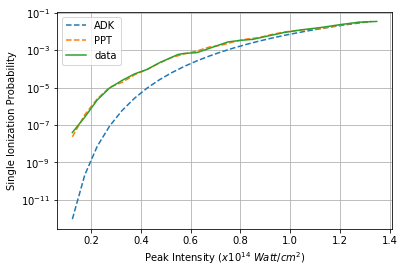

In [32]:
import matplotlib.pyplot as plt
plt.plot(I, Padk*adkr,'--', label='ADK')
plt.plot(I, Pppt*pptr,'--', label="PPT")
#
plt.plot(i,p, label='data')
plt.legend()
plt.yscale('log')
plt.grid()
plt.xlabel('Peak Intensity ($x10^{14}$ $Watt/cm^2$)')
plt.ylabel('Single Ionization Probability')
plt.show()